## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import numpy as np
import os
import h5py
import keras
import itertools

# 神經網絡正規化
from keras.regularizers import l1, l2, l1_l2 
# 神經網絡隨機拋棄、批次標準化、激活函數
from keras.layers import Dense, Dropout, BatchNormalization, Activation 
# Early Stopping
from keras.callbacks import EarlyStopping
# 自動存取目前模型的最佳權重
from keras.callbacks import ModelCheckpoint
# Reduce Learning Rate
from keras.callbacks import ReduceLROnPlateau
# 訓練模型時，利用 callback 紀錄訓練過程
from keras.callbacks import Callback
# 自訂損失函數
import tensorflow as tf
import keras.backend as K

import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data( )

170500096/170498071 [==============================] - 4s 0us/step


# 資料前處理 - 標準化 及 獨熱編碼(OneHot Encoding)

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 - Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

# 建立神經網絡模型

In [5]:
def build_mlp( input_shape, output_units = 10, num_neurons = [ 512, 256, 128 ], pre_activate = False ) : 
    
    input_layer = keras.layers.Input( input_shape )
    
    for i, n_units in enumerate( num_neurons ) : 
        if i == 0 :
            x = keras.layers.Dense( units = n_units, 
                                    activation = "relu", 
                                    name = "Hidden_Layer_" + str( i+1 ) )( input_layer )  
            
            if pre_activate :
                # Batch Normalization Layer before Activation Function 
                x = BatchNormalization( name = "BN_Layer_" + str( i+1 ) )( x )
                x = Activation( 'relu', name = 'Activation_' + str( i+1 ) )( x )
            else :
                x = Activation( 'relu', name = 'Activation_' + str( i+1 ) )( x )
                x = BatchNormalization( name = "BN_Layer_" + str( i+1 ) )( x )
            
            
            
        else :
            x = keras.layers.Dense( units = n_units, 
                                    activation = "relu",  
                                    name = "Hidden_Layer_" + str( i+1 ) )( x )  
            
            if pre_activate :
                # Batch Normalization Layer before Activation Function
                x = BatchNormalization( name = "BN_Layer_" + str( i+1 ) )( x )
                x = Activation( 'relu', name = 'Activation_' + str( i+1 ) )( x )
            else :
                x = Activation( 'relu', name = 'Activation_' + str( i+1 ) )( x )
                x = BatchNormalization( name = "BN_Layer_" + str( i+1 ) )( x )
                          
              
    output_layer = keras.layers.Dense( units = output_units, 
                                       activation = 'softmax', 
                                       name = 'Output_Layer' )( x )
    
    model = keras.models.Model( inputs = [ input_layer ], outputs = [ output_layer ] )
    return model

model = build_mlp( input_shape = x_train.shape[ 1: ] ) 
model.summary( )

W0727 06:34:02.753725 139640289625984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 06:34:02.800360 139640289625984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 06:34:02.808163 139640289625984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 06:34:02.936481 139640289625984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
Activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
BN_Layer_1 (BatchNormalizati (None, 512)               2048      
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
Activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
BN_Layer_2 (BatchNormalizati (None, 256)               1024      
__________

# 設定超參數

In [0]:
EPOCHS = 50
BATCH_SIZE = 1024

PRE_ACTIVATE = True       # Batch Normalization Layer before activation function 

LEARNING_RATE = 1e-3      # for optimizer
MOMENTUM = 0.95           # for optimizer 

# PATIENCE = [ 10, 25 ]     # for early stopping
REDUCE_LR_FACTOR = [ 0.25 ] # for reduce learning rate
REDUCE_LR_PATIENCE = [ 5 ]  # for reduce learning rate

CE_Weight_list = [ 0., 0.3, 0.5, 0.7, 1 ]  # Weights of Cross Entropy for customizd loss function

# 優化器(Optimizer)

In [0]:
SGD = keras.optimizers.SGD( lr = LEARNING_RATE, 
                            momentum = MOMENTUM, 
                            nesterov = True
                            )

Optimizers = 'SGD'

# 自訂損失函數(Loss Function)  
  * Focal Loss :  
    $FL( p_t ) = - \alpha \cdot ( 1 - p_t )^\gamma \cdot \ln( p_t ) $,  
    where   
    $ p_t = p $, if $ y = 1 $ ; $= 1 - p$, o.w. ;  
    $\gamma \geq 0 $ is called the focusing parameter.  
  * Focal Loss = Cross Entropy if $\alpha = \gamma = 1$.
  
 Reference :  
 1. [機器/深度學習: 損失函數(loss function)- Huber Loss和 Focal loss ](https://medium.com/@chih.sheng.huang821/機器-深度學習-損失函數-loss-function-huber-loss和-focal-loss-bb757494f85e)  
 2. [Focal Loss](https://blog.csdn.net/u014380165/article/details/77019084)  
 3. [Focal Loss for Dense Object Detection](https://arxiv.org/pdf/1708.02002.pdf) 
 
 Python Code Referneces :   
 1. [What does it mean to reduce axis?](https://medium.com/@aerinykim/tensorflow-101-what-does-it-mean-to-reduce-axis-9f39e5c6dea2)  
 2. [keras-focal-loss](https://github.com/aldi-dimara/keras-focal-loss/blob/master/focal_loss.py)

In [0]:
"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss( gamma = 2., alpha = 4., ce_weights = 0.7 ) :
    gamma = float( gamma )
    alpha = float( alpha )
    fl_weights = 1 - ce_weights
    
    def CEL_FL( y_true, y_pred ) :
        # Focal Loss(FL) for multi-classification
        """
        FL( p_t ) = - alpha * ( 1 - p_t )^{ gamma } * ln( p_t )
        """
        epsilon = K.epsilon( )
        y_true = tf.convert_to_tensor( y_true, tf.float32 )
        y_pred = tf.convert_to_tensor( y_pred, tf.float32 )

        # Clip the prediction value
        model_out = K.clip( y_pred, epsilon, 1.0 - epsilon )
        #model_out = tf.add( y_pred, epsilon )
        
        # Calculate cross entropy
        Cross_Entropy = tf.multiply( y_true, -tf.log( model_out ) )
        
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = tf.multiply( y_true, tf.pow( tf.subtract( 1., model_out ), gamma ) )
        
        # Calculate Focal Loss
        FL = tf.multiply( alpha, tf.multiply( weight, Cross_Entropy ) )
        reduced_FL = tf.reduce_max( FL, axis = 1 )
        
        # Calculate Cross Entropy Loss
        CE_Loss = keras.losses.categorical_crossentropy( y_true, y_pred )
        
        return ( ce_weights * CE_Loss ) + ( fl_weights * tf.reduce_mean( reduced_FL ) )
    
    return CEL_FL


# 訓練模型

In [9]:
results = { }

for i, ce_w in enumerate( CE_Weight_list ) :
          
    keras.backend.clear_session( )    # 清掉舊的 Graph 
    
    print( 'Weight of Cross Entropy = ' + str( ce_w ) )
    
    # Early Stopping
    #EARLY_STOP = EarlyStopping( monitor = "val_loss", 
    #                            patience = PATIENCE,  # 容忍訓練無再改善時的 EPOCHS 次數
    #                            verbose = 1
    #                            )
    
    # Model Check Point( 自動存取目前模型的最佳權重 )
    #ModelCheckPoint = ModelCheckpoint( filepath = './weights.best.h5' ,
    #                                   monitor = 'val_acc', 
    #                                   save_best_only = True
    #                                   )
    
    model = build_mlp( input_shape = x_train.shape[ 1: ], pre_activate = PRE_ACTIVATE )
    model.summary( )
    

    
    # 執行神經網絡
    model.compile( loss = combined_loss( gamma = 2, alpha = 0.25, ce_weights = ce_w ), 
                   optimizer = Optimizers, 
                   metrics = [ 'accuracy' ] 
                   )
    
    # Reduce Learning Rate ( when a metric has stopped improving! )
    #Reduce_LR = ReduceLROnPlateau( factor = reduce_factor, # new_lr = lr * factor
    #                               min_lr = 1e-12,         # lower bound on lr
    #                               monitor = 'val_loss', 
    #                               patience = reduce_patience,  # number of epochs with no improvement after which lr will be reduced
    #                               verbose = 1
    #                               )
    
    model.fit( x_train, y_train, 
               epochs = EPOCHS,     
               validation_data = ( x_test, y_test ), 
               # validation_split = 0.2,  # Fraction of the training data to be used as validation data.
               batch_size = BATCH_SIZE, 
               #callbacks = [ EARLY_STOP ],
               #callbacks = [ Reduce_LR, Record_TPTN ],
               #callbacks = [rec_tptn]
               shuffle = True
               )
    
    # Collect results
    train_loss = model.history.history[ 'loss' ]
    valid_loss = model.history.history[ 'val_loss' ]
    train_acc = model.history.history[ 'acc' ]
    valid_acc = model.history.history[ 'val_acc' ] 
    #valid_f1sc = model.history.history[ 'val_f1sc' ]
    
    exp_name_tag = 'Learning Rate =' + str( LEARNING_RATE ) + ', Optimizer:' + str( Optimizers ) + ', CE Weight =' + str( ce_w  )  
    results[ exp_name_tag ] = { 'Train Loss': train_loss,
                                'Valid Loss': valid_loss,
                                'Train Acc': train_acc,
                                'Valid Acc': valid_acc
                                }     

W0727 06:34:03.419156 139640289625984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



Weight of Cross Entropy = 0.0


W0727 06:34:03.752198 139640289625984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
BN_Layer_1 (BatchNormalizati (None, 512)               2048      
_________________________________________________________________
Activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
BN_Layer_2 (BatchNormalizati (None, 256)               1024      
_________________________________________________________________
Activation_2 (Activation)    (None, 256)               0         
__________

W0727 06:34:03.974622 139640289625984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 213us/step - loss: 0.5427 - acc: 0.1544 - val_loss: 0.5049 - val_acc: 0.2049
Epoch 2/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.4646 - acc: 0.2217 - val_loss: 0.4674 - val_acc: 0.2298
Epoch 3/50
50000/50000 [==============================] - 9s 188us/step - loss: 0.4295 - acc: 0.2553 - val_loss: 0.4436 - val_acc: 0.2502
Epoch 4/50
50000/50000 [==============================] - 9s 187us/step - loss: 0.4074 - acc: 0.2773 - val_loss: 0.4228 - val_acc: 0.2689
Epoch 5/50
50000/50000 [==============================] - 9s 187us/step - loss: 0.3916 - acc: 0.2964 - val_loss: 0.4083 - val_acc: 0.2876
Epoch 6/50
50000/50000 [==============================] - 9s 188us/step - loss: 0.3789 - acc: 0.3135 - val_loss: 0.3998 - val_acc: 0.2990
Epoch 7/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.3688 - acc: 0.3265 - val_loss: 0.3913 -

# 損失函數及準確率

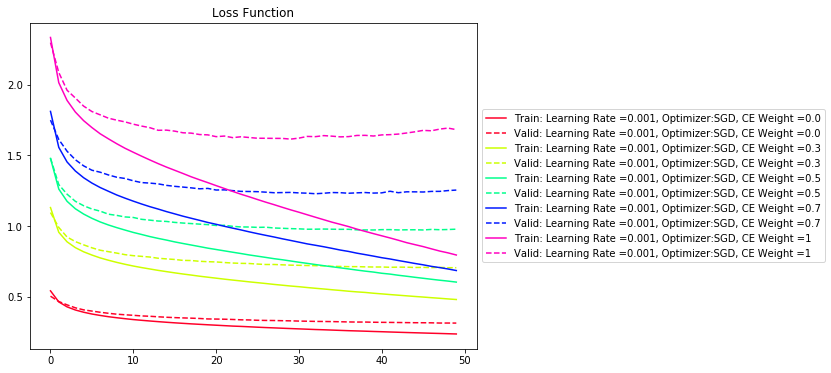

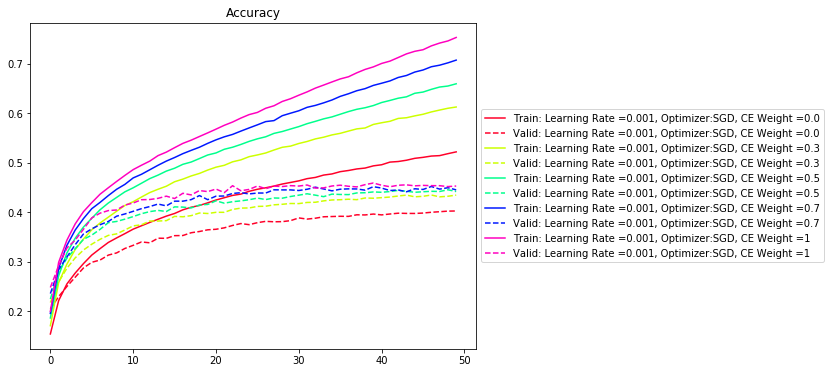

In [10]:
NUM_COLORS = len( results.keys( ) )
cm = plt.get_cmap( 'gist_rainbow' )
cNorm  = colors.Normalize( vmin = 0, vmax = NUM_COLORS - 1 )
scalarMap = mplcm.ScalarMappable( norm = cNorm, cmap = cm )
color_bar = [ scalarMap.to_rgba( i ) for i in range( NUM_COLORS ) ]

plt.figure( figsize = ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot( range( len( results[cond]['Train Loss']) ), results[cond]['Train Loss'], '-', label = 'Train: ' + cond, color = color_bar[i] )
    plt.plot( range( len( results[cond]['Valid Loss']) ), results[cond]['Valid Loss'], '--', label = 'Valid: ' + cond, color = color_bar[i] )
plt.title( 'Loss Function' )
plt.legend( loc = 'center left', bbox_to_anchor = ( 1, 0.5 ) )
plt.show( )

plt.figure( figsize= ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot( range( len( results[cond]['Train Acc']) ), results[cond]['Train Acc'], '-', label = 'Train: ' + cond, color = color_bar[i] )
    plt.plot( range( len( results[cond]['Valid Acc']) ), results[cond]['Valid Acc'], '--', label = 'Valid: ' + cond, color = color_bar[i] )
plt.title( 'Accuracy' )
plt.legend( loc = 'center left', bbox_to_anchor = ( 1, 0.5 ) )
plt.show( )